In [117]:
import numpy as np
import random
import math
from operator import itemgetter
import matplotlib.pyplot as plt
from copy import deepcopy, copy

# Collection of unary and binary functions

In [118]:
##binary##
def addition(vector):
    a = 0
    for i in vector:
        if a > 1e+6: return 1e+6
        elif a < -1e+6: return -1e+6
        elif a < 1e-6 and a > 0: return 1e-6
        elif a > -1e-6 and a < 0: return -1e-6
        else: a += i
    return a

def multiplication(vector):
    a = 1
    for i in vector:
        if a > 1e+6: return 1e+6
        elif a < -1e+6: return -1e+6
        elif a < 1e-6 and a > 0: return 1e-6
        elif a > -1e-6 and a < 0: return -1e-6
        else: a *= i
    return a

def maximum(vector):
    return max(vector)

def minimum(vector):
    return min(vector)
##unary##
def relu(a):
    if a < 0: return 0
    else:
        if a > 1e+6: return 1e+6
        else: return a

def identity(a):
    return a

def pow_two(a):
    if a > 1e+3 or a < -1e+3: return 1e+6
    elif a < 1e-3 and a > 0: return 1e-6
    elif a > -1e-3 and a < 0: return 1e-6
    else: return a * a
    
def negative(a):
    return -a

def irer(a):
    if a < 1e-6 and a > 0: return 1e-6 #return math.sqrt(a)
    elif a > -1e-6 and a < 0: return -1e-6 #return -math.sqrt(math.fabs(a))
    else:
        if a < 0: return -math.sqrt(math.fabs(a))
        elif a > 0: return math.sqrt(a)
        else: return 0
    
def reverse(a):
    if a > 1e+6: return 1e-6
    elif a < -1e+6: return -1e-6
    elif a < 1e-6 and a > 0: return 1e+6
    elif a > -1e-6 and a < 0: return -1e+6
    elif a == 0.0: return 1e+6
    else: return 1.0/a

def exp(a):
    if a > 14: return 1e+6
    elif a < -14: return 1e-6
    elif a < 1e-6 and a > 0: return 1
    elif a > -1e-6 and a < 0: return 1
    else: return math.exp(a)

def natlog(a):
    if a > 1e+6: return 1e+6
    elif a <= 0: return 0
    elif a < 1e-6 and a > 0: return -1e+6
    else: return math.log(a)

def logic(a):
    if a >= 0: return 1
    else: return 0
    
def cosinus(a):
    if a > 1e+6: return math.cos(1e+6)
    elif a < 1e-6 and a > 0: return math.cos(1e-6)
    elif a < -1e+6: return math.cos(-1e+6)
    elif a > -1e-6 and a < 0: return math.cos(-1e-6)
    return math.cos(a)

def sinus(a):
    if a > 1e+6: return math.sin(1e+6)
    elif a < 1e-6 and a > 0: return math.sin(1e-6)
    elif a < -1e+6: return math.sin(-1e+6)
    elif a > -1e-6 and a < 0: return math.sin(-1e-6)
    return math.sin(a)

def cubicroot(a):
    if a < 1e-6 and a > 0: return 1e-6
    if a > -1e-6 and a < 0: return -1e-6
    else: return a ** (1/3)

def atan(a):
    return math.atan(a)

def cubic(a):
    if a > 1e+2: return 1e+6
    elif a < -1e+2: return -1e+6
    elif a > -1e-2 and a < 0: return -1e-6
    elif a < 1e-2 and a > 0: return 1e-6
    else: return a*a*a

# Parametric genetic algorithm

In [119]:
class BaseGenetics(object):
    def __init__(self, e=None):
        self.estimator = None
        self.expectations = e # vector of math expectations for each component
        
    def set_estimator(self, f):
        def g(*args, **kwargs):
            return f(*args, **kwargs)
        self.estimator = g
        
    def generate_population(self, qmin, qmax, h, m):
        """
        Generate population.
        
        (real, real, int, int) -> [h x m] np.array of reals
        """
        population = {}
        e = self.expectations
        if e:
            functional = self.estimate_object_function(e)
            population[functional] = e
            while len(population) < h:
                candidate = np.random.normal(e, 0.03)
                functional = self.estimate_object_function(candidate)
                if functional < 1e+3: population[functional] = candidate
        else:
            while len(population) < h:
                candidate = np.random.uniform(qmin, qmax, m)
                functional = self.estimate_object_function(candidate)
                if functional < 1e+3: population[functional] = candidate
        return population
    
    def estimate_object_function(self, q):
        """
        Evaluates function self.estimator with q as an incoming parameter
        
        (vector) -> real
        """
        return self.estimator(q)

    
    def get_best_individual(self, population, worst=False, ksearch=None):
        """
        Return best or worst individual:
        1) if ksearch != None and worst==False: return best individual
        from ksearch random sample without replacement.
        2) if ksearch == None and worst==True: return index of the worst
        individual from the whole population.

        (2d array of real, bool, int) -> array of real OR int
        """
        population_estimates = np.array(list(population.keys()))
        if ksearch and not worst:
            try:
                subpopulation_estimates = population_estimates[np.random.choice(population_estimates.shape[0], ksearch, replace=False)]
                individual_estimate = subpopulation_estimates.min()
                return (population[individual_estimate], individual_estimate)
            except ValueError as e: print('Wrong type for ksearch: {0}'.format(e))
        else:
            best_estimate = population_estimates.min()
            return (population[best_estimate], best_estimate)
    
    def cross(self, population, ksearch):
        """
        Processes crossover of some individuals.

        (array of array of reals, int) -> (array of real, array of real) OR None
        """
        best_individual, best_value = self.get_best_individual(population)
        if len(best_individual) > 1:
            parent1, parent1_est = self.get_best_individual(population, worst=False, ksearch=ksearch)
            parent2, parent2_est = self.get_best_individual(population, worst=False, ksearch=ksearch)
            if np.max([best_value/parent1_est, best_value/parent2_est])>np.random.uniform():
                crossover_point = np.random.randint(1, len(parent1) - 1)
                child1 = np.hstack((parent1[:crossover_point], parent2[crossover_point:]))
                child2 = np.hstack((parent2[:crossover_point], parent1[crossover_point:]))
                return (child1, child2)
            else: return None
        elif len(best_individual) == 1: return (best_individual[:], best_individual[:])
        else: print('fuck you')
        
    def mutate(self, children, qmin, qmax, p=1):
        """
        Mutate given child1 and child2 with probability 'p'.

        (array of real, array of real, real, real, real) -> None
        """
        if np.random.rand() < p:
            mutated_children = {}
            for child in children:
                child_gene = np.random.randint(child.shape[0])
                child[child_gene] = np.random.uniform(qmin, qmax)
                child_functional = self.estimate_object_function(child)
                mutated_children[child_functional] = child
            return mutated_children
        else: return None
        
    def insert_children(self, population, children):
        """
        Replace the worst individuals with children, if they fit better.

        (2d array of real, array of real, array of real) -> None
        """
        merge = {**children, **population}
        k = len(children)
        estimates = list(merge.keys()) # unique estimates
        bad_k = np.partition(estimates, k)[-k:]
        for e in bad_k: del merge[e]
        return merge
                
    # psi_change_epoch <= individuals
    # ksearch <= individuals
    # variations_per_individuals >= 1
    # g > 0
    # crossings > 0
    
    def optimize(self, qmin=1, qmax=4, individuals=1000, generations=10,
                       individual_len=3, crossings=256, ksearch=16):
        print('Generating population for parametric optimization...')
        population = self.generate_population(qmin, qmax, individuals, individual_len)
        for g in range(generations):
            for c in range(crossings):
                children = self.cross(population, ksearch)
                if children:
                    children = self.mutate(children, qmin, qmax)
                    population = self.insert_children(population, children)
                    if len(population) <= ksearch:
                        print('Population died out!')
                        best_individual, best_value = self.get_best_individual(population)
                        print('J: {0}, Q: {1}'.format(best_value, best_individual))
                        return best_individual, best_value
                else: continue
            best_individual, best_value = self.get_best_individual(population)
            print('J: {0}, Q: {1}'.format(best_value, best_individual))
        return best_individual, best_value

# Model

In [120]:
class Robot():
    def __init__(self, time, x0, y0, tetta0, xf, yf, tettaf):
        self.x_history = [x0]
        self.y_history = [y0]
        self.tetta_history = [tetta0]
        self.time_history = [0.0]
        self.control_history = [(0.0, 0.0)]
        self.sim_time = time
        self.xf = xf
        self.yf = yf
        self.tettaf = tettaf
        self.eps = 0.01
        self.control_func = None
        self.dt = 0.01
        
    def set_control_function(self, f):
        def g(*args, **kwargs):
            return f(*args, **kwargs)
        self.control_func = g
    
    def set_dt(self, dt):
        self.dt = dt
    
    def simulate(self, dt=0.01):    
        t = dt
        su = 0
        x1, y1 = 5, 5
        rad = 2.5
        while t < self.sim_time:
            new_x, new_y, new_tetta = self.__euler_step(dt)
            if new_x == 1e+6: return 1e+6
            try: 
                dr = math.pow(rad, 2) - math.pow(x1 - new_x, 2) - math.pow(y1 - new_y, 2)
                if dr > 0: su = su + 1
            except: pass
            estimation = self.estimate()
            if estimation > 1e+6: return 1e+6   
            self.x_history.append(new_x)
            self.y_history.append(new_y)
            self.tetta_history.append(new_tetta)
            self.time_history.append(t)
            if estimation < self.eps: return t
            t += dt
        return self.sim_time + estimation + su * dt
    
    def __euler_step(self, dt):
        x, y, tetta = self.__get_current_coords()
        dx, dy, dtetta = self.__get_right_parts(tetta)
        if dx > 1e+6 or dy > 1e+6 or dtetta > 1e+6: return 1e+6, 1e+6, 1e+6
        tilda_x = x + dt * dx
        tilda_y = y + dt * dy
        tilda_tetta = tetta + dt * dtetta
        
        tdx, tdy, tdtetta = self.__get_right_parts(tilda_tetta)
        x = x + (dx + tdx) * 0.5 * dt
        y = y + (dy + tdy) * 0.5 * dt
        tetta = tetta + (dtetta + tdtetta) * 0.5 * dt
        return x, y, tetta
    
    def __get_right_parts(self, tetta):
        current_coords = self.__get_current_coords()
        terminal_coords = self.__get_terminal_coords()
        state = terminal_coords - current_coords
        u1, u2 = self.control_func(state)
        self.clip_control(u1)
        self.clip_control(u2)
        self.control_history.append((u1, u2))
        right_x = (u1 + u2) * np.cos(tetta) * 0.5
        right_y = (u1 + u2) * np.sin(tetta) * 0.5
        right_tetta = (u1 - u2) * 0.5
        return right_x, right_y, right_tetta

    def clip_control(self, u):
        if u < -10: return -10
        elif u > 10: return 10
        else: return u
    
    def __get_current_coords(self,):
        return np.array([self.x_history[-1], self.y_history[-1], self.tetta_history[-1]])
    
    def __get_terminal_coords(self,):
        return np.array([self.xf, self.yf, self.tettaf])
    
    def estimate(self,):
        v0 = self.__get_current_coords()
        vf = self.__get_terminal_coords()
        return np.linalg.norm(vf - v0)
    
    def reset(self,):
        self.x_history = [self.x_history[0]]
        self.y_history = [self.y_history[0]]
        self.tetta_history = [self.tetta_history[0]]
        self.time_history = [0.0]
        self.control_histroy = [(0.0, 0.0)]
    
    def get_coords(self,):
        return (self.x_history, self.y_history)
    
    def get_control_in_time(self,):
        return (self.time_history, self.control_history)
    
    def plot_trajectory(self,):
        x, y = self.get_coords()
        fig = plt.figure()
        plt.plot(x, y, 'r')
        plt.xlabel('${x}$',fontsize=20)
        plt.ylabel('${y}$',fontsize=20)
        plt.legend(['${y}({x})$'],loc='upper right')
        plt.show()

# Network Operator

In [121]:
class NetworkOperator(object):
    """
    
    """
    def __init__(self, unaries, binaries, input_nodes, output_nodes):
        """
        Instantiates Network Operator object
        xq - list of variables and parameters
        unaries - list of unary functions
        binaries - list of binary functions
        """
        self.psi = None
        self.base_psi = None
        self.un_dict = {ind: func for ind, func in enumerate(unaries)}
        self.bin_dict = {ind: func for ind, func in enumerate(binaries)}
        self.q = []
        self.base_q = []
        self.__input_node_free_index = None
        self.output_nodes = output_nodes # list of indexes that output nodes posess
        self.input_nodes = input_nodes # list of indexes that input nodes posess
  
    def get_input_nodes(self,):
        return self.input_nodes
    
    def set_q(self, q):
        """
        q - list
        return dict
        """
        self.q = {ind: val for ind, val in enumerate(q)}
        self.__input_node_free_index = len(q)

    def get_q(self,):
        return self.q
    
    def set_base_q(self, q):
        self.base_q = {ind: val for ind, val in enumerate(q)}
        self.__input_node_free_index = len(q)
        
    def get_base_q(self,):
        return self.base_q
    
    def update_base_q(self,):
        new_q = copy(self.get_q()).values()
        self.set_base_q(new_q)
        
    def roll_back_to_base_q(self,):
        old_q = copy(self.get_base_q()).values()
        self.set_q(old_q)
        
    def get_free_input_node(self,):
        return self.__input_node_free_index
    
    def variate_parameters(self, index, value):
        q = self.get_q()
        q[index] = value
        
    def get_psi(self,):
        return self.psi

    def set_psi(self, psi):
        self.psi = psi 
    
    def get_base_psi(self,):
        return self.base_psi
        
    def set_base_psi(self, base_psi):
        self.base_psi = base_psi
        
    def update_base_psi(self,):
        new_psi = deepcopy(self.get_psi())
        self.set_base_psi(new_psi)
        
    def roll_back_to_base_psi(self,):
        old_psi = deepcopy(self.get_base_psi())
        self.set_psi(old_psi)
    
    def get_unary_dict_keys(self,):
        return list(self.un_dict.keys())
    
    def get_binary_dict_keys(self,):
        return list(self.bin_dict.keys())
    
    def eval_psi(self, x):
        """
        out_nodes - indexes of nodes which are outputs of nop. [list]
        x - list of state components
        """
        x = {self.get_free_input_node() + ind: val for ind, val in enumerate(x)}
        xq = {**self.q, **x} # merge two dicts without altering the originals
        d = {} # node: value
        psi = self.get_psi()
        def apply_unary(unary_func, unary_index):
            try: return unary_func(xq[unary_index]) # try to apply unary to q or x
            except: return unary_func(d[unary_index]) # apply unary to a dictinoary with that node otherwise
        for cell in psi:
            binary_index = cell[-1][1] # binary operation index
            binary_func = self.bin_dict[binary_index] # binary function object
            d[cell[-1][0]] = binary_func([apply_unary(self.un_dict[i[1]], i[0]) for i in cell[:-1]])
        nop_outputs = tuple([d[node] for node in self.output_nodes])
        return nop_outputs

# Structural genetic algorithm

In [125]:
class StructureGenetics(object):
    """
    
    """
    def __init__(self, nop, model):
        self.nop = nop
        self.model = model
        self.model.set_control_function(nop.eval_psi)
        self.base_estimation = None
        self.qmin = None
        self.qmax = None
    
    def generate_variations_population(self, individuals, variations_per_individual):
        """
        Generate population.
        
        (int, int) -> np.array of integers (shape: [h x m x 4])
        """
        population = {}
        while len(population) < individuals:
            individual = [self.generate_variation(mutate_param=False) for i in range(variations_per_individual)]
            functional = self.estimate_variation(individual)
            if functional < 1e+3: population[functional] = individual
        return population

    def estimate_object_function(self,):
        """
        Evaluates function self.estimator with q as an incoming parameter
        
        (vector) -> real
        """
        functional = self.model.simulate()
        self.model.reset()
        return functional

    def estimate_variation(self, variation_matrix):
        for variation in variation_matrix:
            if variation[0] != 3: # first we apply all kinds of variations except of the delete
                self.apply_variation(variation)
        for variation in variation_matrix:
            if variation[0] == 3: # then we apply delete variation
                self.apply_variation(variation)
        a = self.nop.get_psi()
        b = self.nop.get_base_psi()
        c = self.nop.get_q()
        d = self.nop.get_base_q()
        if a == b and c == d: est = self.base_estimation
        else: est = self.estimate_object_function()            
        self.nop.roll_back_to_base_psi()
        self.nop.roll_back_to_base_q()
        return est

    ### function to insert into parametric optimization ###
    def estimate_parameters(self, q):
        self.nop.set_q(q)
        functional = self.estimate_object_function()
        return functional
    #######################################################

    def get_best_individual(self, population, ksearch=None):#, worst=False, ksearch=None):
        """
        Return best or worst individual:
        1) if ksearch != None and worst==False: return best individual
        from ksearch random sample without replacement.
        2) if ksearch == None and worst==True: return index of the worst
        individual from the whole population.

        (2d array of real, bool, int) -> array of real OR int
        """
        population_estimates = np.array(list(population.keys()))
        if ksearch:# and not worst:
            try:
                subpopulation_estimates = population_estimates[np.random.choice(population_estimates.shape[0], ksearch, replace=False)]
                individual_estimate = subpopulation_estimates.min()
                return (population[individual_estimate], individual_estimate)
            except ValueError as e: print('Wrong type for ksearch: {0}'.format(e))
        else:
            best_estimate = population_estimates.min()
            return (population[best_estimate], best_estimate)
       
    def generate_variation(self, mutate_param=False):
        psi = self.nop.get_base_psi()
        var_num = random.randint(0,4)
        #var_num = np.random.choice(5, p=[0.1, 0.1, 0.1, 0.1, 0.6])
        sublist_index = random.randint(0, len(psi) - 1) # operand column index 
        un_keys_list = self.nop.get_unary_dict_keys()
        bin_keys_list = self.nop.get_binary_dict_keys()
        if var_num == 4 or mutate_param: # nop must have at least one parameter
            param_index = random.randrange(0, self.nop.get_free_input_node())
            new_value = random.uniform(self.qmin, self.qmax)
            if not mutate_param: return [4, param_index, new_value, None]
            else: return [4, mutate_param, new_value, None]
        elif var_num == 0: # change binary operation
            bin_keys_list = self.nop.get_binary_dict_keys()
            new_bin_op = random.choice(bin_keys_list)
            c = random.randint(0, max(un_keys_list[-1], bin_keys_list[-1]))
            return [0, sublist_index, c, new_bin_op]
        elif var_num == 1: # change unary operation
            un_keys_list = self.nop.get_unary_dict_keys()
            l = len(psi[sublist_index])
            unary_cell = random.randint(0, l - 2) # except binary node
            new_un_op = random.choice(un_keys_list)
            return [1, sublist_index, unary_cell, new_un_op]
        elif var_num == 2: # add unary operation
            new_un_op = random.choice(un_keys_list)
            if sublist_index == 0:
                node = random.choice(self.nop.get_input_nodes())
            else:
                node = random.randint(0, psi[sublist_index-1][-1][0])
            return [2, sublist_index, node, new_un_op]
        elif var_num == 3: # delete unary operation
            a = random.randrange(0, len(psi))
            b = random.randrange(0, len(psi[a]))
            c = random.randint(0, max(un_keys_list[-1], bin_keys_list[-1]))
            index_to_start_from_delete = None
            exclude = []
            inputs = self.nop.get_input_nodes()
            for i in inputs:
                for ind, val in enumerate(psi):
                    for j, v in enumerate(val):
                        if v[0] == i:
                            exclude.append((ind, j))
                            break
                    break
                continue
            left_bound = max(exclude, key=itemgetter(0)) # (sublist_index, tuple_index)
            sublist_index = random.randint(left_bound[0], len(psi)-1)
            l = len(psi[sublist_index])
            if l > 3: # if that column has more than one operand
                if sublist_index == left_bound[0]:
                    sample_indices = [j for j, v in enumerate(psi[sublist_index][:-1]) if j != left_bound[1]]
                    if sample_indices:
                        cell_to_del = random.choice(sample_indices)
                    else:
                        return [3, a, b, c]
                else: cell_to_del = random.randint(0, l - 2) # choose random index of the cell, except the last(binary cell)
                node_to_del = psi[sublist_index][cell_to_del][0] # operand row index
                nodes = [list(map(itemgetter(0), sublist[:-1])) for sublist in psi] # all unary nodes (list of lists)
                if sum(x.count(node_to_del) for x in nodes) > 1: return [3, sublist_index, cell_to_del, c] # if more than one occurence 
                else: return [3, a, b, c] # lost graph connectivity
            else: return [3, a, b, c] # lost graph connectivity       

    def apply_variation(self, variation):
        loc_psi = self.nop.get_psi()
        sublist_index = variation[1]
        if variation[0] == 0: # change binary
            new_bin_op = variation[3]
            if new_bin_op > len(self.nop.get_binary_dict_keys()) - 1: return None
            node = loc_psi[sublist_index][-1][0]
            loc_psi[sublist_index][-1] = (node, new_bin_op)
        elif variation[0] == 1: # change unary
            cell = variation[2]
            new_un_op = variation[3]
            if cell >= len(loc_psi[sublist_index]) - 1: return None
            elif new_un_op > len(self.nop.get_unary_dict_keys()) - 1: return None
            node = loc_psi[sublist_index][cell][0]
            loc_psi[sublist_index][cell] = (node, new_un_op)
        elif variation[0] == 2: # add unary
            node = variation[2]
            new_un_op = variation[3]
            if new_un_op > len(self.nop.get_unary_dict_keys()) - 1: return None
            new_cell = (node, new_un_op)
            _ = loc_psi[sublist_index].pop()
            loc_psi[sublist_index].append(new_cell)
            loc_psi[sublist_index].append(_)
        elif variation[0] == 3: # delete unary
            node_to_del = variation[2]
            if len(loc_psi[sublist_index]) < 3: return None
            elif node_to_del >= len(loc_psi[sublist_index]) - 1: return None
            else:
                for ind, sublist in enumerate(loc_psi[:sublist_index]):
                    if sublist[-1][0] == node_to_del:
                        nodes = [list(map(itemgetter(0), sublist[:-1])) for sublist in loc_psi[ind + 1:]]
                        break
                else:
                    nodes = [list(map(itemgetter(0), sublist[:-1])) for sublist in loc_psi]
                if sum(x.count(node_to_del) for x in nodes) > 1:
                    del loc_psi[sublist_index][node_to_del]
                else:
                    return None
        elif variation[0] == 4: # change parameter
            param_index = variation[1]
            new_value = variation[2]
            self.nop.variate_parameters(param_index, new_value)
                
    def cross(self, population, ksearch, var_num, children_num=8):
        best_individual, best_value = self.get_best_individual(population)
        parent1, parent1_est = self.get_best_individual(population, ksearch=ksearch)
        parent2, parent2_est = self.get_best_individual(population, ksearch=ksearch)
        if np.max([best_value/parent1_est, best_value/parent2_est]) > np.random.uniform():
            param_len = len(self.nop.get_q())
            all_variations = np.vstack((parent1, parent2))
            new_vars_len = round(0.38 * all_variations.shape[0])
            _ = [self.generate_variation(mutate_param=i%param_len) for i in range(new_vars_len)]
            _ = np.reshape(_, (-1, 4))
            all_variations = np.vstack((all_variations, _))
            sex = lambda: all_variations[np.random.choice(all_variations.shape[0], var_num, replace=False), :]
            ch = [sex() for i in range(children_num)]
            children = {}
            for child in ch:
                functional = self.estimate_variation(child)
                children[functional] = child
            return children
        else: return None
            
    def insert_children(self, population, children):
        """
        Replace the worst individuals with children, if they fit better.

        (2d array of real, array of real, array of real) -> None
        """
        merge = {**children, **population}
        k = len(children)
        estimates = list(merge.keys()) # unique estimates
        bad_k = np.partition(estimates, k)[-k:]
        for e in bad_k: del merge[e]
        return merge
    
    def emigrate(self, pop_len_before, variations_per_individual, population):
        pop_len_after = len(population)
        emigration_len = pop_len_after - pop_len_before
        emigration = {}
        while len(population) < pop_len_before:
            individual = [self.generate_variation(mutate_param=False) for i in range(variations_per_individual)]
            functional = self.estimate_variation(individual)
            if functional < 1e+3: population[functional] = individual
        return population
    
    def change_base_psi(self, individual):
        """ Apply variations in individual to the structure
        :param individual: list of lists of objects
        :return: None
        """
        for variation in individual:
            self.apply_variation(variation)
        self.nop.update_base_psi()
        self.nop.update_base_q()

    def optimize(self, qmin=-10, qmax=10, individuals=100, generations=256, psi_change_epoch=2,
                       variations_per_individual=4, crossings=256, ksearch=16):
        self.qmin = qmin
        self.qmax = qmax
        parameters_len = len(self.nop.get_q())
        print('Initializing hyper-parameters...')
        print('''qmin: {0}, qmax: {1}\nPopulation size: {2}\nMax variations number for each individual: {3}\nGenerations: {4}\nCrossings per epoch: {5}\nksearch: {6}\nGeneration to change psi: each {7}th'''.format(
                 qmin, qmax, individuals, variations_per_individual, generations, crossings, ksearch, psi_change_epoch))
        print('Beginning structure synthesis with parameters: {0}'.format(list(self.nop.get_q().values())))
        print('Generating population for structure synthesis...')
        pop_gen_func = lambda: self.generate_variations_population(individuals, variations_per_individual)
        population = pop_gen_func()
        self.base_estimation = self.estimate_object_function() # estimation of base psi
        print('J: {0}'.format(self.base_estimation))
        for g in range(generations):
            print('Generation {0} is running...'.format(g))
            if g % psi_change_epoch == 0 and g != 0 and generations > psi_change_epoch:
                candidate = self.estimate_variation(best_individual)
                if candidate < self.base_estimation:
                    self.change_base_psi(best_individual)
                    self.base_estimation = candidate
                else:
                    print('Proceeding with no changes applied to structure and parameters')
                    continue
                print('Refreshing parameters: \n{0}'.format(list(self.nop.get_q().values())))
                print('Refreshing base structure: \n{0}'.format(self.nop.get_base_psi()))
                print('J: {0}'.format(best_value))
                print("#####################################################")
            for c in range(crossings):
                children = self.cross(population, ksearch, variations_per_individual, children_num=4)
                if children is not None:
                    population = self.insert_children(population, children)
                    population = self.emigrate(individuals, variations_per_individual, population)
                else: continue
            best_individual, best_value = self.get_best_individual(population)
        candidate = self.estimate_variation(best_individual)
        if candidate < self.base_estimation:
            self.change_base_psi(best_individual) # final psi/q change
            self.base_estimation = candidate
        print('Optimizing parameters with fixed structure:\n{0}'.format(self.nop.get_base_psi()))
        gaussian_means = list(self.nop.get_base_q().values())
        pg = BaseGenetics(e=gaussian_means)
        pg.set_estimator(self.estimate_parameters)
        best_q, best_estimation = pg.optimize(qmin, qmax,
                                              individuals,
                                              generations,
                                              parameters_len,
                                              crossings,
                                              ksearch)
        print('Done.')
        print('J: {0}\nQ: {1}\nStructure:\n{2}'.format(best_estimation, best_q, self.nop.get_base_psi()))
        

# Robot & genetics setup

In [126]:
if __name__=='__main__':
    # 1) Instantiate model
    time = 2.3
    x0 = 10
    y0 = 10
    tetta0 = 0
    xf = 0
    yf = 0
    tettaf = 0
    robot = Robot(time, x0, y0, tetta0, xf, yf, tettaf)
    # 2) Instantiate network operator
    unaries = [identity, negative, pow_two, negative, sinus, logic, cosinus, atan, exp, natlog, irer, cubic]#, cubicroot]#reverse, 
    binaries = [addition, multiplication, maximum, minimum]
    input_nodes = [0, 1, 2, 3, 4, 5]
    output_nodes = [9, 10]
    nop = NetworkOperator(unaries, binaries, input_nodes, output_nodes)
    q = [1.68258017, 0.68013064, 1.72779495]
    nop.set_q(q) # set some parameters
    nop.update_base_q() # set those parameters as base as well
    #psi = [[(0, 0), (3, 0), (5, 6), (6, 1)], [(1, 0), (4, 0), (7, 0)], [(2, 0), (5, 5), (0, 8), (8, 1)], [(6, 4), (7, 0), (8, 0), (9, 0)], [(6, 0), (7, 0), (8, 5), (6, 8), (10, 0)]]
    #with obsticle:
    psi = [[(0, 7), (4, 7), (4, 1), (6, 1)], [(0, 8), (1, 5), (7, 3)], [(2, 3), (5, 0), (3, 10), (2, 4), (8, 0)], [(6, 10), (8, 11), (0, 11), (7, 10), (9, 3)], [(6, 0), (7, 10), (8, 0), (1, 3), (1, 4), (1, 1), (2, 6), (2, 0), (4, 10), (4, 0), (4, 0), (4, 0), (7, 1), (9, 6), (5, 5), (10, 0)]]
    nop.set_psi(psi) # set some structure
    nop.update_base_psi() # set this structure as base as well
    # 3) Instantiate structure genetic and pass model with nop to it
    sg = StructureGenetics(nop, robot)
    # 4) Set synthesis parameters
    #%lprun -f sg.optimize sg.optimize(qmin=-10, qmax=10, individuals=256, g=10, psi_change_epoch=2, variations_per_individual=8, r=32, ksearch=20)
    
    # psi_change_epoch <= individuals
    # ksearch <= individuals
    # variations_per_individuals >= 1
    # g > 0
    # crossings > 0
    
    sg.optimize(qmin=-5, qmax=5,
                individuals=1000,
                generations=10,
                psi_change_epoch=2,
                variations_per_individual=10,
                crossings=30,
                ksearch=15)
    

Initializing hyper-parameters...
qmin: -5, qmax: 5
Population size: 1000
Max variations number for each individual: 10
Generations: 10
Crossings per epoch: 30
ksearch: 15
Generation to change psi: each 2th
Beginning structure synthesis with parameters: [1.68258017, 0.68013064, 1.72779495]
Generating population for structure synthesis...
J: 2.6365342463062897
Generation 0 is running...
Generation 1 is running...
Generation 2 is running...
Refreshing parameters: 
[3.947676505901823, 0.68013064, 1.72779495]
Refreshing base structure: 
[[(0, 7), (4, 1), (4, 7), (6, 3)], [(0, 5), (1, 5), (7, 3)], [(2, 3), (5, 0), (3, 10), (2, 4), (8, 0)], [(6, 5), (8, 11), (7, 10), (9, 3)], [(6, 0), (7, 10), (8, 0), (1, 3), (1, 4), (2, 6), (2, 0), (4, 10), (4, 0), (4, 0), (4, 0), (7, 1), (9, 6), (5, 5), (10, 0)]]
J: 2.370669902168956
#####################################################
Generation 3 is running...
Generation 4 is running...
Proceeding with no changes applied to structure and parameters
Gener

# Plot u(t), y(x) and obsticles

## Coordinates

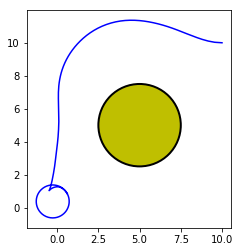

In [129]:
robot.simulate()
x, y = robot.get_coords()
plt.axes()
circle = plt.Circle((5, 5), radius=2.5, lw=2.0, fc='y', edgecolor='black')
plt.gca().add_patch(circle)
plt.plot(x, y, 'b')
plt.axis('scaled')
plt.show()